In [9]:
! pip install torchvision

In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # Input: 1 channel (grayscale)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)  # Flattened size after conv layers
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the output from convolution layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)  # Output: 1 channel (grayscale)
    
    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 128, 8, 8)  # Reshape to the appropriate size for deconvolution
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        recon_x = torch.sigmoid(self.deconv3(z))  # Use sigmoid to get pixel values between 0 and 1
        return recon_x

In [13]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)  # Reparameterization trick
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [14]:
# Loss function: combines reconstruction loss and KL divergence
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss: binary cross-entropy (for grayscale images)
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 64*64), x.view(-1, 64*64), reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


In [15]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((64, 64)),                 # Resize images to 64x64
    transforms.ToTensor()                        # Convert images to tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root="photos_classes", transform=transform)

# Limit to 500 images per class
class_indices = defaultdict(list)

# Group indices by class
for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

# Fetch first 500 images for each class
subset_indices = []
for indices in class_indices.values():
    subset_indices.extend(indices[:500])

# Create a subset dataset
subset_dataset = Subset(dataset, subset_indices)

# DataLoader for the subset
dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Get class names
class_names = dataset.classes
print("Classes:", class_names)
print("Number of images in subset:", len(subset_dataset))


Classes: ['drink', 'food', 'inside', 'menu', 'outside']
Number of images in subset: 2500


In [16]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Assume `dataloader` is predefined
epochs = 300
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for images, _ in dataloader:  # dataloader should provide grayscale images
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

Epoch 1, Loss: 164932.20864257813
Epoch 6, Loss: 128097.93284912109
Epoch 11, Loss: 118968.83256835937
Epoch 16, Loss: 114267.08350830078
Epoch 21, Loss: 111275.6544555664
Epoch 26, Loss: 109042.74936523437
Epoch 31, Loss: 106535.63220214844
Epoch 36, Loss: 104547.05364990234
Epoch 41, Loss: 102615.14854736328
Epoch 46, Loss: 101190.67064208984
Epoch 51, Loss: 100500.04346923828
Epoch 56, Loss: 99189.47435302734
Epoch 61, Loss: 98519.18103027344
Epoch 66, Loss: 97856.45911865235
Epoch 71, Loss: 97402.87281494141
Epoch 76, Loss: 96970.57495117188
Epoch 81, Loss: 96749.48397216797
Epoch 86, Loss: 96383.7736328125
Epoch 91, Loss: 96004.55686035156
Epoch 96, Loss: 95780.23411865234
Epoch 101, Loss: 95829.85139160157
Epoch 106, Loss: 95307.29315185547
Epoch 111, Loss: 95194.9796508789
Epoch 116, Loss: 94982.65762939453
Epoch 121, Loss: 94791.51119384766
Epoch 126, Loss: 94675.06755371093
Epoch 131, Loss: 94600.54678955078
Epoch 136, Loss: 94659.03865966797
Epoch 141, Loss: 94240.57147216797

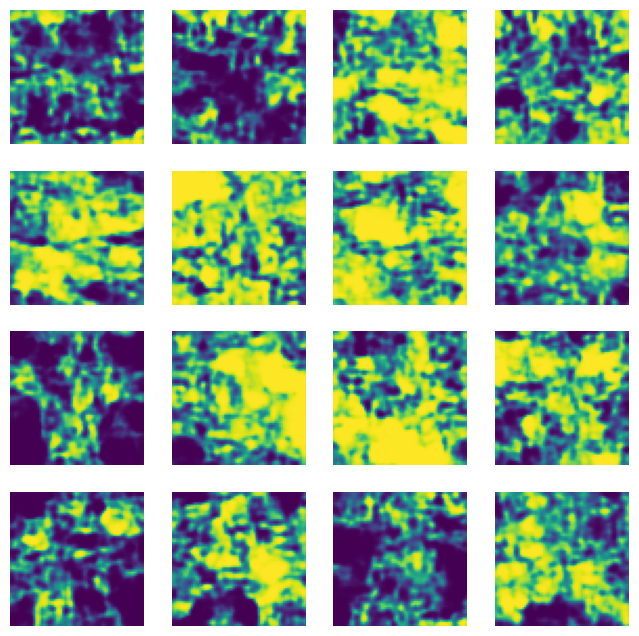

In [17]:
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 128).to(device)  # Generate random latent vectors
    generated_images = vae.decoder(z)
    generated_images = generated_images.cpu()

    # Visualize generated images
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i].permute(1, 2, 0))
        plt.axis("off")
    plt.show()


### Tuning 1

In [18]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load the dataset
dataset = datasets.ImageFolder(root="photos_classes", transform=transform)

# Limit to 500 images per class
class_indices = defaultdict(list)

# Group indices by class
for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

# Fetch first 500 images for each class
subset_indices = []
for indices in class_indices.values():
    subset_indices.extend(indices[:500])

# Create a subset dataset
subset_dataset = Subset(dataset, subset_indices)

# DataLoader for the subset
dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Get class names
class_names = dataset.classes
print("Classes:", class_names)
print("Number of images in subset:", len(subset_dataset))


Classes: ['drink', 'food', 'inside', 'menu', 'outside']
Number of images in subset: 2500


In [19]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1)
        
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [20]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
    
    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 256, 8, 8)  # Reshape
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        recon_x = torch.tanh(self.deconv3(z))  # Output in [-1, 1]
        return recon_x

In [21]:
# VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)  # Reparameterization trick
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [22]:
def loss_function(recon_x, x, mu, logvar, beta=0.001):
    # Reconstruction loss: Mean Squared Error (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss


In [23]:
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=64).to(device)  # Reduced latent dimension
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 300
vae.train()

for epoch in range(epochs):
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar, beta=0.001)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")
        # Save example reconstructions
        with torch.no_grad():
            recon_images, _, _ = vae(images[:16])
            recon_images = (recon_images + 1) / 2  # Scale back to [0, 1]
            save_image(recon_images, f"reconstruction_epoch_{epoch + 1}.png", normalize=True)


Epoch 1, Loss: 133625.94954833985
Epoch 6, Loss: 60769.66322021485
Epoch 11, Loss: 47446.288403320315
Epoch 16, Loss: 35513.44415283203
Epoch 21, Loss: 28475.223837280275
Epoch 26, Loss: 24056.880700683592
Epoch 31, Loss: 21532.0636138916
Epoch 36, Loss: 19611.65753173828
Epoch 41, Loss: 19199.05495300293
Epoch 46, Loss: 16671.411517333985
Epoch 51, Loss: 14489.581297302246
Epoch 56, Loss: 12010.704655456542
Epoch 61, Loss: 11714.257405090331
Epoch 66, Loss: 11745.509649658203
Epoch 71, Loss: 11701.865751647949
Epoch 76, Loss: 11883.943696594239
Epoch 81, Loss: 11445.47922668457
Epoch 86, Loss: 11212.670579528809
Epoch 91, Loss: 11183.46574859619
Epoch 96, Loss: 10962.342152404784
Epoch 101, Loss: 10194.193346405029
Epoch 106, Loss: 8964.119822692872
Epoch 111, Loss: 8840.738847351075
Epoch 116, Loss: 8790.772814941407
Epoch 121, Loss: 8846.092649841308
Epoch 126, Loss: 8909.165010070801
Epoch 131, Loss: 8872.171635437011
Epoch 136, Loss: 8801.408044433594
Epoch 141, Loss: 8752.5345787

In [24]:
# Save the model state_dict (weights)
def save_model(vae, file_path="models/vae_model_300epochs.pth"):
    torch.save(vae.state_dict(), file_path)
    print(f"Model saved to {file_path}")

# Example usage
save_model(vae)


Model saved to models/vae_model_300epochs.pth


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10436\3842473525.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("models/vae_model_300epochs

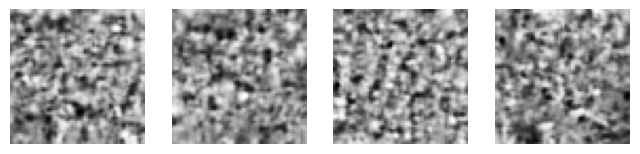

In [25]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Function to generate and display high-quality images
def generate_and_display_high_quality_images(vae, num_images, latent_dim):
    vae.eval()  # Set VAE to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Sample random latent vectors
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)  # Standard normal distribution
        generated_images = vae.decoder(z)  # Decode to generate images
    
    # Rescale images to [0, 1] for visualization
    generated_images = (generated_images + 1) / 2

    # Create a plot for the images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    if num_images == 1:
        axes = [axes]  # Make it iterable if only one image is generated

    for i, ax in enumerate(axes):
        # Handle the case when generated image tensor is in shape (C, H, W)
        image = generated_images[i].cpu().squeeze(0)  # Remove the batch dimension
        # Check if the image is grayscale (1 channel) or RGB (3 channels)
        if image.dim() == 2:  # Grayscale image
            ax.imshow(image.numpy(), cmap='gray')
        elif image.dim() == 3:  # RGB image
            ax.imshow(image.permute(1, 2, 0).numpy())  # Change from (C, H, W) to (H, W, C)
        ax.axis('off')  # Hide axis

    plt.show()

# Example usage
latent_dim = 64  # Higher latent dimension for better quality
vae = VAE(latent_dim=latent_dim).to(device)  # Ensure this is your trained model
vae.load_state_dict(torch.load("models/vae_model_300epochs.pth"))  # Load the trained model weights

# Generate 4 high-quality images
generate_and_display_high_quality_images(vae, num_images=4, latent_dim=latent_dim)


## Tuning2

In [26]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load the dataset
dataset = datasets.ImageFolder(root="photos_classes", transform=transform)

# Limit to 500 images per class
class_indices = defaultdict(list)

# Group indices by class
for idx, (_, label) in enumerate(dataset):
    class_indices[label].append(idx)

# Fetch first 1000 images for each class
subset_indices = []
for indices in class_indices.values():
    subset_indices.extend(indices[:1000])
    print(len(subset_indices))

# Create a subset dataset
subset_dataset = Subset(dataset, subset_indices)

# DataLoader for the subset
dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

# Get class names
class_names = dataset.classes
print("Classes:", class_names)
print("Number of images in subset:", len(subset_dataset))


1000
2000
3000
3700
4700
Classes: ['drink', 'food', 'inside', 'menu', 'outside']
Number of images in subset: 4700


In [27]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # Input: 1 channel (grayscale)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Updated the number of features based on the new input size (128x128)
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)  # After 4 convolution layers
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [28]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)  # Match the encoder's final feature size
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)  # Output 1 channel (grayscale)
    
    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 256, 8, 8)  # Reshape to match the deconvolution input
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        recon_x = torch.tanh(self.deconv4(z))  # Output in [-1, 1]
        return recon_x


In [29]:
# VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)  # Reparameterization trick
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [30]:
def loss_function(recon_x, x, mu, logvar, beta=0.001):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # Use MSE for reconstruction loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return recon_loss + beta * kl_loss


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=64).to(device)  # Latent dim = 64, you can adjust based on your needs
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 500
vae.train()

for epoch in range(epochs):
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar, beta=0.001)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")
        # Save example reconstructions
        with torch.no_grad():
            recon_images, _, _ = vae(images[:16])
            recon_images = (recon_images + 1) / 2  # Scale back to [0, 1]
            save_image(recon_images, f"reconstruction_epoch_{epoch + 1}.png", normalize=True)


Epoch 1, Loss: 649817.0819256756
Epoch 6, Loss: 307894.5187922297
Epoch 11, Loss: 272315.07453547296
Epoch 16, Loss: 233856.8311866554
Epoch 21, Loss: 203761.36391469595
Epoch 26, Loss: 186055.1948902027
Epoch 31, Loss: 175138.39336993243
Epoch 36, Loss: 165980.50675675675
Epoch 41, Loss: 158714.44679054053
Epoch 46, Loss: 153583.53357263515
Epoch 51, Loss: 143153.80711570947
Epoch 56, Loss: 130911.80394847973
Epoch 61, Loss: 129825.32669974663
Epoch 66, Loss: 129451.70676731419
Epoch 71, Loss: 127687.69298986487
Epoch 76, Loss: 126353.50205869932
Epoch 81, Loss: 125061.49978885135
Epoch 86, Loss: 125491.9153293919
Epoch 91, Loss: 123210.37827280405
Epoch 96, Loss: 122774.61343961148
Epoch 101, Loss: 117222.2265625
Epoch 106, Loss: 111871.11011402027
Epoch 111, Loss: 111617.0655616554
Epoch 116, Loss: 111713.67652027027
Epoch 121, Loss: 111669.30637668919
Epoch 126, Loss: 111147.92403927365
Epoch 131, Loss: 110539.93195734797
Epoch 136, Loss: 110664.71252111487
Epoch 141, Loss: 109342.

KeyboardInterrupt: 

In [ ]:
# Save the model state_dict (weights)
def save_model(vae, file_path="models/vae_model_500epochs.pth"):
    torch.save(vae.state_dict(), file_path)
    print(f"Model saved to {file_path}")

# Example usage
save_model(vae)

Model saved to models/vae_model_500epochs.pth


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17400\645708039.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("models/vae_model_500epochs.

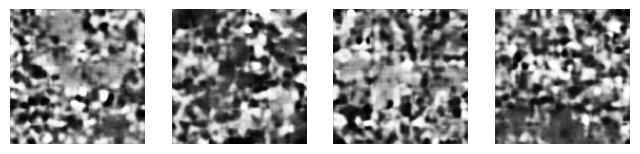

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Function to generate and display high-quality images
def generate_and_display_high_quality_images(vae, num_images, latent_dim):
    vae.eval()  # Set VAE to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Sample random latent vectors
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)  # Standard normal distribution
        generated_images = vae.decoder(z)  # Decode to generate images
    
    # Rescale images to [0, 1] for visualization
    generated_images = (generated_images + 1) / 2

    # Create a plot for the images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    if num_images == 1:
        axes = [axes]  # Make it iterable if only one image is generated

    for i, ax in enumerate(axes):
        # Handle the case when generated image tensor is in shape (C, H, W)
        image = generated_images[i].cpu().squeeze(0)  # Remove the batch dimension
        # Check if the image is grayscale (1 channel) or RGB (3 channels)
        if image.dim() == 2:  # Grayscale image
            ax.imshow(image.numpy(), cmap='gray')
        elif image.dim() == 3:  # RGB image
            ax.imshow(image.permute(1, 2, 0).numpy())  # Change from (C, H, W) to (H, W, C)
        ax.axis('off')  # Hide axis

    plt.show()

# Example usage
latent_dim = 64  # Higher latent dimension for better quality
vae = VAE(latent_dim=latent_dim).to(device)  # Ensure this is your trained model
vae.load_state_dict(torch.load("models/vae_model_500epochs.pth"))  # Load the trained model weights

# Generate 4 high-quality images
generate_and_display_high_quality_images(vae, num_images=4, latent_dim=latent_dim)


Model Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Specify the latent dimension used during training
latent_dim = 64  # Replace with the correct latent_dim

# Initialize the model
vae = VAE(latent_dim).to(device)

# Load the state dictionary
state_dict = torch.load("./models/vae_model_500epochs.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
vae.load_state_dict(state_dict)

# Set the model to evaluation mode
vae.eval()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17096\1213737984.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./models/vae_model_500epochs.pth",

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=16384, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=16384, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=16384, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
vae

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=16384, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=16384, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=16384, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.utils import make_grid
from scipy.linalg import sqrtm
import numpy as np
from PIL import Image
import os


In [ ]:

# Load Pretrained InceptionV3 model
def load_inception_model():
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = torch.nn.Identity()  # Remove the classification layer
    inception.eval()
    return inception




In [ ]:
import matplotlib.pyplot as plt
import torch

def display_last_generated_images(images, num_last=5):
    """
    Display the last N generated images.

    Args:
        images (torch.Tensor): Tensor of generated images, shape [N, C, H, W].
        num_last (int): Number of last images to display.
    """
    # Ensure images are in the range [0, 1] for display
    if images.max() > 1:
        images = images / 255.0
    images = images.cpu().detach()

    # Convert grayscale to RGB if necessary
    if images.shape[1] == 1:  # Grayscale: [N, 1, H, W]
        images = images.repeat(1, 3, 1, 1)  # Repeat the channel dimension 3 times

    # Select the last N images
    images = images[-num_last:]  # Slice the last num_last images
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, num_last, i + 1)
        plt.imshow(image.permute(1, 2, 0))  # Convert [C, H, W] to [H, W, C] for display
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from PIL import Image
from scipy.linalg import sqrtm
import numpy as np
import torch.nn.functional as F

# # Define transformations for InceptionV3
# def preprocess_images_for_inception(images, resize=299):
#     print("Preprocessing Image")
#     transform = transforms.Compose([
#         Resize((resize, resize)),  # Resize to 299x299 for InceptionV3
#         Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Inception normalization
#     ])
#     return torch.stack([transform(image) for image in images])

# Compute Inception Score
def compute_inception_score(images, inception, device, splits=10):
    print("Computing Inception Score")
    images = images.to(device)
    with torch.no_grad():
        preds = F.softmax(inception(images), dim=1).cpu().numpy()  # Predict class probabilities
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)

# Compute Frechet Inception Distance (FID)
def compute_fid(real_activations, fake_activations):
    print("Calculating FID Score")
    mu1, sigma1 = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Generate images using the VAE model
def generate_images(vae, num_samples, latent_dim, device):
    print("Generaing")
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample latent vectors
        generated_images = vae.decoder(z)  # Decode to images
        generated_images = generated_images.clamp(0, 1)  # Ensure values are in the range [0, 1]
    display_last_generated_images(generated_images)
    return generated_images

# Preprocess images for InceptionV3
def preprocess_images_for_inception(images, resize=299):
    transform = transforms.Compose([
        transforms.Resize((resize, resize)),  # Resize to 299x299 for InceptionV3
        transforms.Lambda(lambda img: img.repeat(3, 1, 1)),  # Duplicate the grayscale channel to 3 channels (RGB)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for Inception
    ])
    # Ensure images are float tensors
    images = images.float() if images.dtype == torch.uint8 else images
    images = images / 255.0 if images.max() > 1 else images  # Normalize to [0, 1] if needed
    return torch.stack([transform(image) for image in images])



# Evaluation function using ImageFolder
def evaluate_vae(vae, real_images_path, num_generated=500, latent_dim=64, device='cpu'):
    print("Evaluating VAE")
    # Load the real images using ImageFolder
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Resize to match InceptionV3
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for Inception
    ])
    real_dataset = datasets.ImageFolder(root=real_images_path, transform=transform)

    # Limit to 500 images per class (or fewer if not enough images)
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(real_dataset):
        class_indices[label].append(idx)

    subset_indices = []
    for indices in class_indices.values():
        subset_indices.extend(indices[:num_generated])

    subset_dataset = Subset(real_dataset, subset_indices)
    real_dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=False)

    # Load pretrained InceptionV3
    inception = load_inception_model().to(device)

    # Generate images
    generated_images = generate_images(vae, num_generated, latent_dim, device)

    # Compute real activations
    real_activations = []
    for real_images, _ in real_dataloader:
        real_images = real_images.to(device)
        with torch.no_grad():
            real_activations.append(inception(real_images).cpu().numpy())
    real_activations = np.concatenate(real_activations, axis=0)

    # Compute fake activations
    generated_images = preprocess_images_for_inception(generated_images).to(device)
    with torch.no_grad():
        fake_activations = inception(generated_images).cpu().numpy()

    # Compute Inception Score
    inception_score, inception_std = compute_inception_score(generated_images, inception, device)

    # Compute FID
    fid = compute_fid(real_activations, fake_activations)

    print(f"Inception Score: {inception_score} ± {inception_std}")
    print(f"Frechet Inception Distance: {fid}")
    return inception_score, fid

Evaluating VAE
Generaing


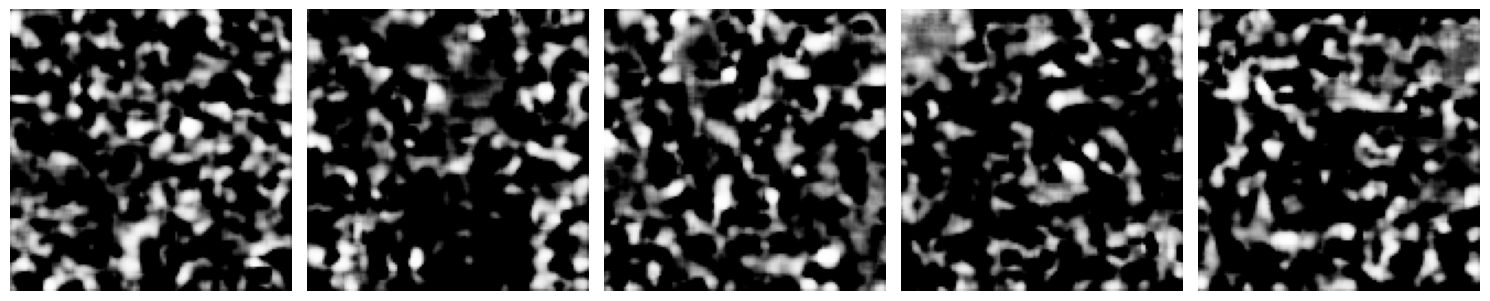

Computing Inception Score
Calculating FID Score
Inception Score: 1.0 ± 0.0
Frechet Inception Distance: 2.405975797261313e+100


In [ ]:
if __name__ == "__main__":
    VAE_MODEL_PATH = "models/vae_model_500epochs.pth"  # Path to the saved VAE model
    REAL_IMAGES_PATH = "./photos_classes"  # Path to the folder with real images
    NUM_SAMPLES = 10
    LATENT_DIM = 64

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # # Load the VAE model
    # vae = torch.load(VAE_MODEL_PATH, map_location=device)
    # vae = vae.to(device)

    # Evaluate the VAE
    evaluate_vae(vae, REAL_IMAGES_PATH, num_generated=NUM_SAMPLES, latent_dim=LATENT_DIM, device=device)


Evaluating VAE
Generaing


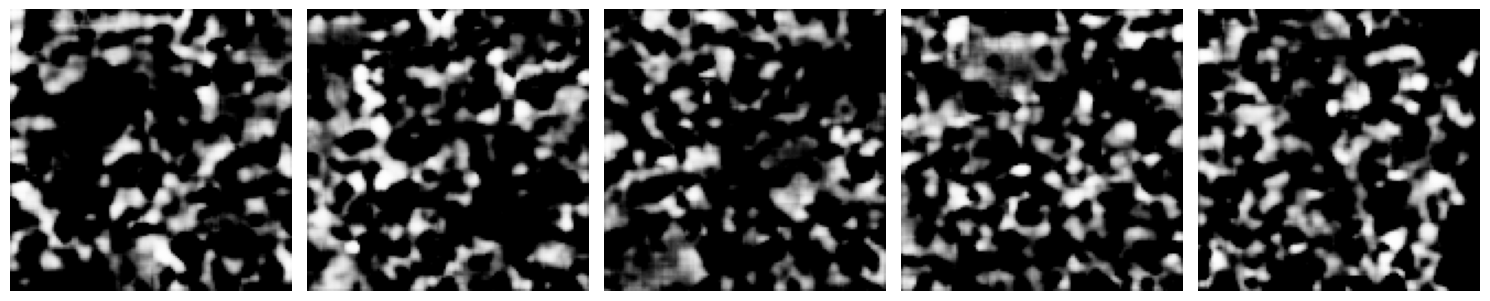

Computing Inception Score
Calculating FID Score
Inception Score: 1.034101128578186 ± 0.0015635418239980936
Frechet Inception Distance: 3.0757273703662114e+76


In [ ]:
if __name__ == "__main__":
    VAE_MODEL_PATH = "models/vae_model_500epochs.pth"  # Path to the saved VAE model
    REAL_IMAGES_PATH = "./photos_classes"  # Path to the folder with real images
    NUM_SAMPLES = 500
    LATENT_DIM = 64

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate the VAE
    evaluate_vae(vae, REAL_IMAGES_PATH, num_generated=NUM_SAMPLES, latent_dim=LATENT_DIM, device=device)


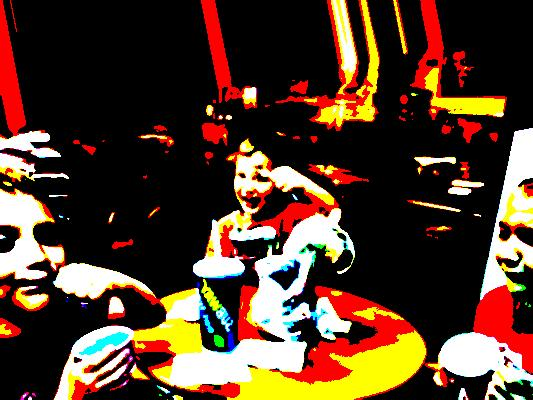

In [ ]:
Image.open("photos_classes/drink/augmented_2200.jpg")